<a href="https://colab.research.google.com/github/matthewplk/AI-HW4/blob/main/AI_HW4_1e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

This is an basecode for assignment 4 of Artificial Intelligence class (CSCE-4613), Spring 2023


In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

## Binary Network

## Define a binary network class


In [2]:
class BinaryNetwork(nn.Module):
  def __init__(self, hidden_dims = [2]):
    super(BinaryNetwork, self).__init__()
    self.network_dims = [2] + hidden_dims + [1]
    self.layers = []
    for i, dim in enumerate(self.network_dims[1:]):
      prev_dim = self.network_dims[i]
      dense = nn.Linear(in_features = prev_dim, out_features = dim, bias = True)
      activation = nn.Sigmoid()
      self.layers += [dense, activation]
    self.layers = nn.ModuleList(self.layers)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

### Define data generator

In [3]:
def generate_data(operator = "NOR"):
  assert operator in ["AND", "OR", "XOR", "NOR"], "%s operator is not valid" % operator
  data = []
  label = []
  for i in range(2):
    for j in range(2):
      data.append([i, j])
      if operator == "AND":
        label.append(i & j)
      elif operator == "OR":
        label.append(i | j)
      elif operator == "XOR":
        label.append(i ^ j)
      else:
        label.append(not (i | j))
  data = torch.as_tensor(data, dtype = torch.float32)
  label = torch.as_tensor(label, dtype = torch.float32)
  return data, label

### Define the training framework

BinaryNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
[50/500]. Loss: 0.4681. Accuracy: 75.00
[100/500]. Loss: 0.1763. Accuracy: 100.00
[150/500]. Loss: 0.0549. Accuracy: 100.00
[200/500]. Loss: 0.0288. Accuracy: 100.00
[250/500]. Loss: 0.0191. Accuracy: 100.00
[300/500]. Loss: 0.0142. Accuracy: 100.00
[350/500]. Loss: 0.0112. Accuracy: 100.00
[400/500]. Loss: 0.0092. Accuracy: 100.00
[450/500]. Loss: 0.0078. Accuracy: 100.00
[500/500]. Loss: 0.0068. Accuracy: 100.00
Final Accuracy: 100.00


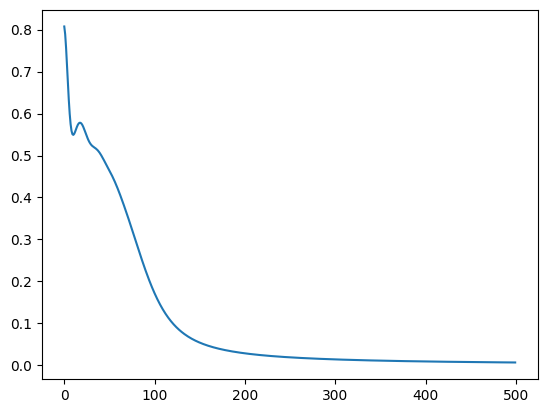

In [6]:
model = BinaryNetwork( hidden_dims= [2])
model.train()
print(model)
operator = "NOR"
inputs, labels = generate_data(operator = operator)
n_iters = 500
learning_rate = 0.1
bce_loss_fn = nn.BCELoss()
optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
threshold = 0.5

losses = []

for i in range(1, n_iters + 1):
  outputs = model(inputs)
  outputs = outputs.reshape(-1)

  loss = bce_loss_fn(outputs, labels)
  predictions = (outputs > threshold).long()

  accuracy = (predictions == labels).float().mean() * 100.

  optim.zero_grad()
  loss.backward()
  optim.step()

  losses.append(loss.item()) #STORE THE LOSS VALUE

  loss = loss.item() # Convert to Python Scalar
  accuracy = accuracy.item() # Convert to Python Scalar

  if i % 50 == 0:
    print("[%d/%d]. Loss: %0.4f. Accuracy: %0.2f" % (i, n_iters, loss, accuracy))

model.eval()
outputs = model(inputs)
outputs = outputs.reshape(-1)
predictions = (outputs > threshold).long()
accuracy = (predictions == labels).float().mean() * 100.
accuracy = accuracy.item()
print("Final Accuracy: %0.2f" % (accuracy))

torch.save(model.state_dict(), "%s_Network.pth" % operator)
  # model.load_state_dict(torch.load("%s_Network.pth" % operator)) # Load model in the next time you use
plt.plot(losses)

## Digit Classification

### Define Digit Classification Network

In [ ]:
class DigitNetwork(nn.Module):
  def __init__(self, hidden_dims = [128]):
    super(DigitNetwork, self).__init__()
    self.network_dims = [28 * 28] + hidden_dims + [10]
    self.layers = []
    for i, dim in enumerate(self.network_dims[1:]):
      prev_dim = self.network_dims[i]
      dense = nn.Linear(in_features = prev_dim, out_features = dim, bias = True)
      if i < len(self.network_dims[1:]) - 1:
        activation = nn.Sigmoid() # Hidden Layer
      else:
        activation = nn.Softmax(dim=1) # Last Layer
      self.layers += [dense, activation]
    self.layers = nn.ModuleList(self.layers)

  def forward(self, x):
    size = x.size()
    x = x.reshape(size[0], -1) # Flatten images
    for layer in self.layers[:-1]:
      x = layer(x)
    if self.training == False:
      x = self.layers[-1](x)
    return x

### Define Data Generator

In [ ]:
def create_data_generator(batch_size = 32, root = "data"):
  train_dataset = torchvision.datasets.MNIST(root = root,
                                             train = True,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
  test_dataset = torchvision.datasets.MNIST(root = root,
                                             train = False,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
  train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size = batch_size,
                                             shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size = batch_size,
                                             shuffle = False)
  return train_loader, test_loader

### Define the training framework

In [ ]:
cuda = torch.cuda.is_available()
batch_size = 32
train_loader, test_loader = create_data_generator(batch_size)
model = DigitNetwork(hidden_dims=[])
print(model)
if cuda:
  model.cuda()
n_epochs = 1
learning_rate = 0.1
optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(1, n_epochs + 1):
  for idx, (images, labels) in enumerate(train_loader):
    if cuda:
      images = images.cuda()
      labels = labels.cuda()

    outputs = model(images)

    loss = loss_fn(outputs, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    predictions = torch.argmax(outputs, 1)
    accuracy = (predictions == labels).float().mean() * 100.

    loss = loss.item() # Convert to Python Scalar
    accuracy = accuracy.item() # Convert to Python Scalar

    if idx % 100 == 0:
      print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(train_loader), loss, accuracy))

torch.save(model.state_dict(), "MNIST_Network.pth")

100%|██████████| 9912422/9912422 [00:00<00:00, 158455495.04it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115587494.11it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72323047.28it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22571716.55it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

DigitNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
Epoch [1/1]. Iter [1/1875]. Loss: 2.28. Accuracy: 6.25
Epoch [1/1]. Iter [101/1875]. Loss: 0.09. Accuracy: 100.00
Epoch [1/1]. Iter [201/1875]. Loss: 0.23. Accuracy: 93.75
Epoch [1/1]. Iter [301/1875]. Loss: 0.22. Accuracy: 93.75
Epoch [1/1]. Iter [401/1875]. Loss: 0.16. Accuracy: 87.50
Epoch [1/1]. Iter [501/1875]. Loss: 0.69. Accuracy: 78.12
Epoch [1/1]. Iter [601/1875]. Loss: 0.39. Accuracy: 90.62
Epoch [1/1]. Iter [701/1875]. Loss: 0.50. Accuracy: 87.50
Epoch [1/1]. Iter [801/1875]. Loss: 0.32. Accuracy: 87.50
Epoch [1/1]. Iter [901/1875]. Loss: 0.36. Accuracy: 84.38
Epoch [1/1]. Iter [1001/1875]. Loss: 0.37. Accuracy: 93.75
Epoch [1/1]. Iter [1101/1875]. Loss: 0.48. Accuracy: 87.50
Epoch [1/1]. Iter [1201/1875]. Loss: 0.75. Accuracy: 87.50
Epoch [1/1]. Iter [1301/1875]. Loss: 0.43. Ac

### Define the evaluation framework

In [ ]:
cuda = torch.cuda.is_available()
batch_size = 1
train_loader, test_loader = create_data_generator(batch_size)
model = DigitNetwork(hidden_dims=[])
if cuda:
  model.cuda()
model.eval()
model.load_state_dict(torch.load("MNIST_Network.pth"))

total_accuracy = 0.0
for idx, (images, labels) in enumerate(test_loader):
  if cuda:
    images = images.cuda()
    labels = labels.cuda()

  outputs = model(images)

  predictions = torch.argmax(outputs, 1)
  accuracy = (predictions == labels).float().mean() * 100.

  accuracy = accuracy.item() # Convert to Python Scalar

  total_accuracy += accuracy

  if idx % 2000 == 0:
    print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))

print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))

Iter [1/10000]. Accuracy: 100.00
Iter [2001/10000]. Accuracy: 100.00
Iter [4001/10000]. Accuracy: 0.00
Iter [6001/10000]. Accuracy: 100.00
Iter [8001/10000]. Accuracy: 100.00
Final Accuracy: 90.94


## Backpropagation

### ReLU Example

In [ ]:
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-defining-new-autograd-functions
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

#### Sigmoid Function


In [ ]:
class MySigmoid(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        # input is a N x C tensor, N is the batch size, C is the dimension of input
        ctx.save_for_backward(input)
        # YOUR CODE HERE
        # return output of sigmoid function

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # YOUR CODE HERE
        # return grad_input

#### Fully Connected Layer

In [ ]:
class MyLinearFunction(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input, weights, bias):
        # input is a N x C tensor, N is the batch size, C is the dimension of input
        # weights is a C x D tensor, C and D are the dimension out input and ouput
        # bias is D tensor
        ctx.save_for_backward(input, weights, bias)
        # YOUR CODE HERE
        # return output of linear function
        return torch.matmul(input, weights) + bias


    @staticmethod
    def backward(ctx, grad_output):
        input, weights, bias = ctx.saved_tensors
        # YOUR CODE HERE
        # return grad_input, grad_weights, grad_bias

class MyLinearLayer(nn.Module):
  # You don't modify this layer
  def __init__(self, in_features = 2, out_features = 4):
    super(MyLinearLayer, self).__init__()
    self.weights = nn.Parameter(torch.randn(in_features, out_features))
    self.bias = nn.Parameter(torch.zeros(out_features))
    self.linear_fn = MyLinearFunction.apply

  def forward(self, input):
    return self.linear_fn(input, self.weights, self.bias)


#### Testing Your Implementation

In [ ]:
class MyLinearNetwork(nn.Module):
  def __init__(self):
    super(MyLinearNetwork, self).__init__()
    self.linear_1 = MyLinearLayer(28 * 28, 128)
    self.sigmoid_fn = MySigmoid.apply
    self.linear_2 = MyLinearLayer(128, 10)
    self.softmax_fn = nn.Softmax(dim=1)

  def forward(self, x):
    size = x.size()
    x = x.reshape(size[0], -1) # Flatten images
    x = self.linear_1(x)
    x = self.sigmoid_fn(x)
    x = self.linear_2(x)
    if self.training == False:
      x = self.softmax_fn(x)
    return x

In [ ]:
cuda = torch.cuda.is_available()
batch_size = 32
train_loader, test_loader = create_data_generator(batch_size)
model = MyLinearNetwork()
print(model)
if cuda:
  model.cuda()
n_epochs = 3
learning_rate = 0.1
optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(1, n_epochs + 1):
  for idx, (images, labels) in enumerate(train_loader):
    if cuda:
      images = images.cuda()
      labels = labels.cuda()

    outputs = model(images)

    loss = loss_fn(outputs, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    predictions = torch.argmax(outputs, 1)
    accuracy = (predictions == labels).float().mean() * 100.

    loss = loss.item() # Convert to Python Scalar
    accuracy = accuracy.item() # Convert to Python Scalar

    if idx % 100 == 0:
      print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(train_loader), loss, accuracy))

total_accuracy = 0.0
model.eval()
for idx, (images, labels) in enumerate(test_loader):
  if cuda:
    images = images.cuda()
    labels = labels.cuda()

  outputs = model(images)

  predictions = torch.argmax(outputs, 1)
  accuracy = (predictions == labels).float().mean() * 100.

  accuracy = accuracy.item() # Convert to Python Scalar

  total_accuracy += accuracy

  if idx % 2000 == 0:
    print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))

print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))